# A4 Part 2: DQN for Cartpole Balance Task

In the previous part, you have implemented the table methods for the cartpole using temporal difference (TD) learning and have some basic understandings of reinforcement learning. In this part, you will implement the Deep Q-Network (DQN) algorithm for the Cartpole Balance task. The DQN algorithm uses a neural network to approximate the Q-function, which allows us to learn a policy for balancing the pole on the cart. You will implement the DQN algorithm, train the agent using the Cartpole Balance task, and visualize the learning progress by plotting the total rewards obtained in each episode.

Let's start with basic imports.

In [1]:
%load_ext autoreload
%autoreload 2

# if you did not install the requirements yet, uncomment the following lines to install them
# !pip install torch
# !pip install dm_control

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple

import torch

# set up interactive matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

## Environment Setup

Ensure that you have the DeepMind Control Suite installed and set up with the CartPole environment. Your environment should provide:
  - **State Observations:** Continuous values representing the pole angle, cart position, velocity, etc.
  - **Discrete Actions:** For example, moving the cart left or right.
  - **Reward Structure:** Define the reward for balancing the pole.
  - **Hyperparameters:** Specify important hyperparameters such as learning rate, discount factor, and exploration strategy.

This is provided in the `src.dqn.DMControlCartPoleWrapper` class, which wraps the DeepMind Control Suite CartPole environment to discretize the continuous state space and provide a reward structure suitable for the DQN algorithm.

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

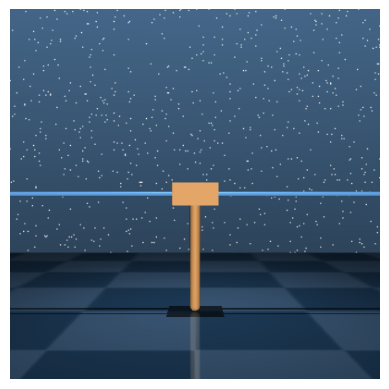

In [2]:
from src.dqn import DMControlCartPoleWrapper

env = DMControlCartPoleWrapper(domain_name="cartpole", task_name="swingup")
frame = env.env.physics.render(height=400, width=400, camera_id=0)
plt.imshow(frame)
plt.axis("off")

### Experience Replay

Experience replay involves storing the agent’s experiences $(s, a, s', r)$ in a replay buffer. During training, random samples from this buffer are used to update the network. This has several advantages:

- **Breaking Correlations:** Random sampling prevents the network from learning spurious correlations that arise from sequential data.
- **Efficient Use of Data:** Each experience is used multiple times in training, making learning more efficient.

The next cell demonstrates how to generate and record one transition and push it into the replay buffer.

In [3]:
from src.dqn import Transition, ReplayMemory


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs, _ = env.reset()
state_t = torch.tensor(obs, device=device, dtype=torch.float32).unsqueeze(0)
action_t = torch.tensor([[1]], device=device, dtype=torch.long)
next_obs, reward_val, term, trunc, _ = env.step(action_t.item())
if not (term or trunc):
    next_state_t = torch.tensor(next_obs, device=device, dtype=torch.float32).unsqueeze(
        0
    )
else:
    next_state_t = None

reward_t = torch.tensor([reward_val], device=device, dtype=torch.float32)
transition = Transition(state_t, action_t, next_state_t, reward_t)
print("transition is ", transition)

# push the transition to the replay memory
replay = ReplayMemory(1000)
replay.push(state_t, action_t, next_state_t, reward_t)

transition is  Transition(state=tensor([[-0.0076, -1.0000, -0.0058, -0.0174, -0.0115]]), action=tensor([[1]]), next_state=tensor([[-0.0073, -1.0000, -0.0064,  0.0799,  0.1289]]), reward=tensor([8.1570e-06]))


### Q-learning basics

In Q learning, we define a state-action value function,  $Q(s, a)$ , which estimates the expected return (sum of discounted rewards) when taking action  $a$  in state  $s$  and thereafter following the optimal policy. The Q function satisfies the Bellman optimality equation:


$$
Q(s, a) = \mathbb{E}_{s'}\left[r(s, a) + \gamma \max_{a'} Q(s', a')\right]
$$


where:
- $r(s, a)$  is the immediate reward received after taking action  $a$  in state  $s$ ,
- $s'$  is the next state,
- $\gamma \in [0,1)$  is the discount factor that weighs future rewards,
- $\max_{a'} Q(s', a')$  represents the best possible future reward obtainable from state  $s'$ .


### Tabular Q Learning Limitations

In the traditional table-based Q learning:
- **Scalability:** A table must be maintained for every state-action pair. For continuous or high-dimensional state spaces (like the one in CartPole), this table becomes enormous or even infinite. (as you might have explored and realized in the previous section)
- **Generalization:** The table cannot generalize across similar states. If the agent encounters a state that’s not exactly in the table, it struggles to estimate a good Q value.


## Deep Q Networks (DQNs)

A DQN approximates the Q function using a neural network parameterized by weights  $\theta$ . Instead of storing discrete Q-values in a table, the network learns a mapping:

$$
Q(s, a; \theta) \approx Q^*(s, a)
$$

where  $Q^*(s, a)$  is the optimal Q-function.

This allows the agent to generalize from seen to unseen states, which is especially useful in environments with continuous state spaces.

### Implementation of DQN in PyTorch

You will implement a PyTorch module for a Deep Q Network (DQN) that maps a state observation to a set of Q-values—one for each possible action. Below is an in-depth description of the implementation:

#### Network Architecture
- **Input Layer:**
The network accepts an input tensor with a size corresponding to the number of observations in the environment. This tensor represents the current state.
- **Hidden Layers:**
The model contains two fully connected (linear) hidden layers:
    - The first hidden layer transforms the input from size n_observations to 128 features.
    - The second hidden layer further processes these 128 features, maintaining the same dimensionality (128 units).
Both hidden layers use the ReLU activation function, which introduces non-linearity and helps the network learn complex state-action value relationships.
- **Output Layer:**
The final layer is another fully connected layer that maps the 128 features to n_actions outputs. Each output corresponds to the Q-value associated with a particular action in the given state. No activation function is applied at this stage because the Q-values can range over all real numbers.

### Forward Pass

The forward method defines how data flows through the network:
1. Input Processing:
The input tensor x is first passed through the first linear layer (layer1), followed by a ReLU activation.
2. Intermediate Representation:
The output of the first layer is then fed into the second linear layer (layer2) and again processed with a ReLU activation, ensuring that the network learns a rich feature representation.
3. Output Computation:
Finally, the transformed data is passed through the third linear layer (layer3), which produces the Q-values for each action. These values are used in the DQN algorithm to estimate the expected rewards for taking different actions in the current state.

Mathematical Overview

The computations performed by the network can be summarized as follows:
1. First Hidden Layer:

$$
h_1 = \text{ReLU}(W_1 x + b_1)
$$

where $W_1 \in \mathbb{R}^{128 \times n\_observations}$ and $b_1 \in \mathbb{R}^{128}$.
2. Second Hidden Layer:

$$
h_2 = \text{ReLU}(W_2 h_1 + b_2)
$$

where $W_2 \in \mathbb{R}^{128 \times 128}$ and $b_2 \in \mathbb{R}^{128}$.

3. Output Layer:

$$
Q(x) = W_3 h_2 + b_3
$$

where $W_3 \in \mathbb{R}^{n\_actions \times 128}$ and $b_3 \in \mathbb{R}^{n\_actions}$.

These equations illustrate how the input state is successively transformed through linear mappings and nonlinear activations, culminating in a vector of Q-values used for decision making.

Now you should implement the DQN model in the `src.dqn.DQN` class.

In [8]:
from src.dqn import DQN

# create an example policy network
policy_net = DQN(env.obs_size, env.action_space_n).to(device)
print(policy_net)

DQN(
  (l1): Linear(in_features=5, out_features=128, bias=True)
  (r1): ReLU()
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (r2): ReLU()
  (l3): Linear(in_features=128, out_features=2, bias=True)
)


[autoreload of src.dqn failed: Traceback (most recent call last):
  File "c:\Users\SmotP\Documents\COGS188\Assignments-WI25\A4\.conda\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\SmotP\Documents\COGS188\Assignments-WI25\A4\.conda\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\SmotP\Documents\COGS188\Assignments-WI25\A4\.conda\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "c:\Users\SmotP\Documents\COGS188\Assignments-WI25\A4\.conda\Lib\site-packages\IPython\extensions\autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\SmotP\Documents\COGS188\Assignments-WI25\A4\.conda\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File

### DQNTrainer: A Comprehensive Guide

The DQNTrainer class encapsulates the training process for a Deep Q-Network (DQN) agent. This guide describes the mathematical foundations of the training process, the role of each function, and specific PyTorch implementation details such as device management, optimizers, and tensor handling.

### Overview of the Training Process

In reinforcement learning, the goal is to learn a policy that maximizes the expected cumulative reward. For Q-learning, we approximate the optimal action-value function  $Q^*(s, a)$ using the Bellman equation:

$$
Q(s, a) = \mathbb{E}{s{\prime}}\left[ r(s, a) + \gamma \max{a{\prime}} Q(s{\prime}, a{\prime}) \right]
$$

Deep Q-Networks (DQN) replace the table-based method with a neural network to approximate  $Q(s, a; \theta)$ . The training objective is to minimize the difference between the predicted Q-values and target Q-values computed using a separate target network. This is formalized by the loss function:

$$
L(\theta) = \mathbb{E}{(s, a, r, s{\prime}) \sim D} \left[ \left( r + \gamma \max{a{\prime}} Q(s{\prime}, a{\prime}; \theta^{-}) - Q(s, a; \theta) \right)^2 \right]
$$

where:
- $\theta$  are the parameters of the current (policy) network.
- $\theta^{-}$  are the parameters of the target network.
- $\gamma$  is the discount factor.
- $D$  is the experience replay buffer.

To stabilize training, experience replay and soft target updates are employed. Experience replay allows the network to learn from a randomized batch of past experiences, while soft updates gradually adjust the target network towards the policy network.

### Class Structure and Function Descriptions

#### 1. Initialization: `__init__`

**Purpose:**

Sets up the training environment by initializing the policy and target networks, the optimizer, and the replay memory.

**Key Operations:**

- Networks:
The policy network  $Q(s, a; \theta)$  and target network  $Q(s, a; \theta^{-})$  are created using the provided observation and action space sizes. The target network is initially synchronized with the policy network.

- Optimizer:
The AdamW optimizer is configured with learning rate `params.LR` and AMSGrad enabled. This is crucial for stable convergence.

- Device Management:
All networks are moved to the specified device (CPU or GPU) to leverage hardware acceleration.

- Hyperparameters:
Parameters such as maximum steps per episode and the number of episodes are stored along with additional training hyperparameters (e.g., learning rate, discount factor  $\gamma$ , epsilon parameters for exploration).


#### 2. Action Selection: `select_action`

**Purpose:**

Chooses an action using an $\epsilon$-greedy policy that balances exploration and exploitation.

**Mathematical Framework:**

- Epsilon Decay:

The exploration rate $\epsilon$ is decayed exponentially:

$$
\epsilon = \epsilon_{\text{end}} + (\epsilon_{\text{start}} - \epsilon_{\text{end}}) \exp\left(-\frac{\text{steps done}}{\epsilon_{\text{decay}}}\right)
$$

- Policy:

With probability $(1 - \epsilon)$, the action $a$ is selected as:

$$
a = \arg\max_{a{\prime}} Q(s, a{\prime}; \theta)
$$

Otherwise, a random action is chosen.

**PyTorch Specifics:**
- The state is provided as a tensor.
- No gradient is computed during the exploitation phase using torch.no_grad().
- The selected action is returned as a tensor.


#### 3. Model Optimization: `optimize_model`

**Purpose:**

Performs one gradient descent update on the policy network using a randomly sampled minibatch from the replay memory.
    
**Steps in the Process:**

1. Sampling the Batch:
A minibatch of transitions  $(s, a, r, s{\prime})$  is sampled from the replay memory.
2. Batch Processing:
The transitions are unpacked, and tensors for states, actions, rewards, and non-terminal next states are prepared.
3. Q-value Calculation:
- Current Q-values:
For each state  $s$  in the batch:

$Q(s, a; \theta) = \text{policy\_net}(s)$  and we select $Q(s, a)$  via \texttt{gather}

- Next Q-values:

For non-terminal states:

$$
\max_{a{\prime}} Q(s{\prime}, a{\prime}; \theta^{-})
$$

Terminal states have a value of 0.

4. Target Computation:
The target Q-value is computed as:

$$
y = r + \gamma \max_{a{\prime}} Q(s{\prime}, a{\prime}; \theta^{-})
$$

5. Loss Calculation:
The loss is computed using the Smooth L1 (Huber) loss:

$$ 
L = \text{SmoothL1Loss}\left(Q(s, a; \theta), y\right)
$$

6. Gradient Descent:
- Gradients are computed via backpropagation.
- Gradient clipping is applied to avoid exploding gradients.
- The optimizer steps to update the network parameters.

**PyTorch Specifics:**

- Use of `torch.no_grad()` ensures that target calculations do not accumulate gradients.
- Tensors are carefully managed on the correct device.
- `torch.nn.utils.clip_grad_value_` is used to clip gradients.


#### 4. Target Network Update: `soft_update`
    
**Purpose:**

Performs a soft update of the target network parameters to slowly track the policy network.

**Mathematical Formulation:**

- For each parameter $\theta_{\text{target}}$ in the target network:

$$
\theta_{\text{target}} \leftarrow \tau \theta_{\text{policy}} + (1 - \tau) \theta_{\text{target}}
$$

where $\tau$ is a small constant (e.g., 0.005) that determines the update rate. This gradual adjustment helps stabilize training.

**Implementation Details:**

- Both the target and policy network state dictionaries are iterated over, and the update is applied element-wise.
- Ensure that the parameters are moved to the appropriate device (CPU/GPU) prior to the update.

#### 5. Training Loop: `train`

**Purpose:**

Executes the main training loop across multiple episodes, integrating all components described above.

**Training Process Overview:**

1. Episode Initialization:
- Reset the environment.
- Convert the initial observation into a tensor on the correct device.
2. Step Loop:
- Action Selection:
The agent selects an action using select_action.
    - Environment Interaction:
The environment returns the next observation, reward, and termination status.
    - Transition Storage:
The experience  $(s, a, s{\prime}, r)$  is stored in the replay memory.
    - Optimization:
The optimize_model method updates the network parameters.
- Target Update:
The soft_update method softly updates the target network.
- Episode Termination:
The loop breaks if the environment signals termination.
3. Episode Reward Tracking:
Total reward per episode is stored and plotted.
4. Completion:
After all episodes, the final reward plot is displayed.

**Mathematical Perspective:**

For each time step  $t$  in an episode:

- The agent observes state  $s_t$  and selects action  $a_t$  using the \epsilon-greedy policy.
- It receives reward  $r_t$  and observes new state  $s_{t+1}$.
- The optimization step minimizes the loss:

$$
L_t(\theta) = \left( r_t + \gamma \max_{a{\prime}} Q(s_{t+1}, a{\prime}; \theta^{-}) - Q(s_t, a_t; \theta) \right)^2
$$

- The network parameters are updated with gradient descent, while the target network is softly updated:

$$
\theta^{-} \leftarrow \tau \theta + (1 - \tau) \theta^{-}
$$

**PyTorch Specifics:**

- All tensors are managed on the specified device (e.g., GPU for faster computation).
- The optimizer `optim.AdamW` is used to update the network parameters.
- States are represented as tensors to enable GPU acceleration and efficient numerical computations.

Training complete


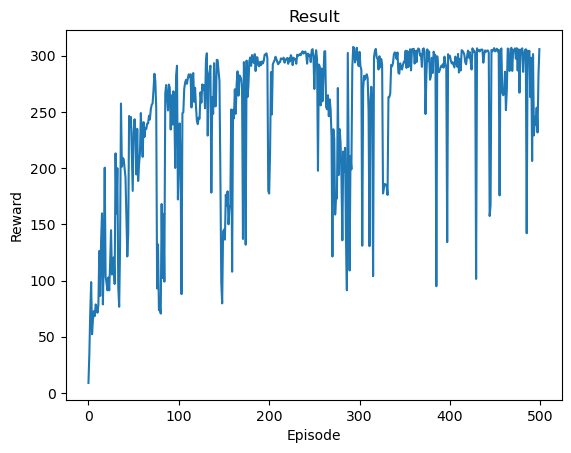

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
from dataclasses import dataclass


@dataclass
class HyperParams:
    BATCH_SIZE: int = 512
    GAMMA: float = 0.99
    EPS_START: float = 0.9
    EPS_END: float = 0.05
    EPS_DECAY: int = 1000
    TAU: float = 0.005
    LR: float = 1e-4


params = HyperParams()
env = DMControlCartPoleWrapper(domain_name="cartpole", task_name="swingup")
# Number of discrete actions
n_actions = env.action_space_n
# Dimensionality of the observations
n_observations = env.obs_size

memory = ReplayMemory(10000)

steps_done = 0

from src.dqn import DQNTrainer

trainer = DQNTrainer(env, memory, device, params, num_episodes=500)
trainer.train()

### Performance Expectations

If you have implemented the DQN algorithm correctly, you should observe your reward curve increasing over time. The agent should learn to swingup and balance the pole on the cart, achieving a high reward in each episode. You should observe at least more than 200 rewards in the majority of episodes after training.

## Evaluate the Agent
In order to run the following cell, which generates a rollout and render the environment, you need to install the `ffmpeg` package. You can install it by running the following command in the terminal:

```bash
sudo apt-get install ffmpeg
```

On macOS, you can install it using `brew`:

```bash
brew install ffmpeg
```


In [10]:
from src.utils import display_video
import base64
from IPython.display import HTML

env = DMControlCartPoleWrapper(domain_name="cartpole", task_name="swingup")

frames = []
obs, _ = env.reset()
state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
terminated = False
truncated = False

while not (terminated or truncated):
    # Capture a frame using dm_control's render
    frame = env.env.physics.render(height=400, width=400, camera_id=1)
    frames.append(frame)

    # Select the best action using policy_net
    with torch.no_grad():
        action = trainer.policy_net(state).max(1)[1].item()

    observation, reward, terminated, truncated, _ = env.step(action)
    if not (terminated or truncated):
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(
            0
        )

display_video(frames)

# Submission:

For this part, you need to submit your implementation of the DQN algorithm for the Cartpole Balance task. You need to implement the `dqn.py` file alongside with the `rewards_plot_dqn.png` file generated.